In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from datetime import datetime as dt


import plotly.express as px
import plotly.graph_objects as go


import itertools

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings
warnings.filterwarnings('ignore')
#pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None) 
pd.set_option('display.float_format', lambda x: '%.f' % x)
pd.set_option('display.expand_frame_repr', False)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/sales-forecasting/train.csv


In [2]:
dataset = pd.read_csv('/kaggle/input/sales-forecasting/train.csv')

In [3]:
df = dataset.copy()

In [4]:
def check_df(dataset, head = 5):
    print('#'*30 + 'Shape of Dataset' + '#'*30, end = '\n'*2)
    print(dataset.shape, end = '\n'*2)
    print('#'*30 + 'General informations about to Dataset' + '#'*30, end = '\n'*2)
    print(dataset.info(), end = '\n'*2)
    print('#'*30 + 'First 5 Lines Of Dataset' + '#'*30, end = '\n'*2)
    print(dataset.head(head), end = '\n'*2)
    print('#'*30 + 'NaN values of Features' + '#'*30, end = '\n'*2)
    print(dataset.isnull().sum(), end = '\n'*2)
    print('#'*30 + 'Descriptive Statistics of Numerical Features' + '#'*30, end = '\n'*2)
    print(dataset.describe().T, end = '\n'*2)
    print('#'*30 + 'Quantiles of Numerical Features' + '#'*30, end ='\n'*2)
    print(dataset.describe([0,0.10, 0.25, 0.50,0.75,0.99]).T, end = '\n'*2)

In [5]:
check_df(df)

##############################Shape of Dataset##############################

(9800, 18)

##############################General informations about to Dataset##############################

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 


In [6]:
df.loc[(df["Postal Code"].isnull()), :][["City", "State"]].value_counts()

City        State  
Burlington  Vermont    11
dtype: int64

In [7]:
df.drop(columns = ['Row ID'], inplace = True) 

df.loc[(df["Postal Code"].isnull()), "Postal Code"] = 5401 #When we look at the observations with an empty Postal Code value in the Data Set, only Vermont - Burlington's Postal Code value is blank. 
                                                            #I am writing this postal code value to blank observations with a Google search.

df["Postal Code"] = df["Postal Code"].astype("str") #I am not doing any arithmetic with the Postal Code variable. So I update the datatype of this variable to int->Str

def convert_datetime(dataframe):      #The data type of the variables containing Date in the dataset is seen as Object. I am changing these string expressions to datetime.
    date_cols = [col for col in dataframe.columns if 'Date' in col]
   
    for col in date_cols:
        dataframe[col] = pd.to_datetime(dataframe[col], errors = 'coerce')
    return dataframe.info()

convert_datetime(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Order ID       9800 non-null   object        
 1   Order Date     9800 non-null   datetime64[ns]
 2   Ship Date      9800 non-null   datetime64[ns]
 3   Ship Mode      9800 non-null   object        
 4   Customer ID    9800 non-null   object        
 5   Customer Name  9800 non-null   object        
 6   Segment        9800 non-null   object        
 7   Country        9800 non-null   object        
 8   City           9800 non-null   object        
 9   State          9800 non-null   object        
 10  Postal Code    9800 non-null   object        
 11  Region         9800 non-null   object        
 12  Product ID     9800 non-null   object        
 13  Category       9800 non-null   object        
 14  Sub-Category   9800 non-null   object        
 15  Product Name   9800 n

In [8]:
import pandas as pd
import plotly.express as px


df['Month-Year'] = df['Order Date'].dt.strftime('%b-%Y')

monthly_sales = df.groupby('Month-Year').agg({'Sales': 'sum'}).reset_index()
monthly_sales['Order'] = pd.to_datetime(monthly_sales['Month-Year'], format='%b-%Y')
monthly_sales = monthly_sales.sort_values('Order')


fig = px.line(monthly_sales, x='Month-Year', y='Sales', title='Monthly Sales',
              labels={'Month-Year': 'Month-Year', 'Sales': 'Sales'})

fig.update_traces(hovertemplate='Date: %{x}<br>Sales: $%{y:,.2f}<extra></extra>')


fig.update_xaxes(tickangle=90, tickmode='array', tickvals=monthly_sales['Month-Year'],
                 ticktext=monthly_sales['Month-Year'])


fig.update_layout(width=900, height=600)


fig.show()


In [9]:
import plotly.graph_objects as go
import plotly.subplots as sp

fig_histogram = go.Figure()

fig_histogram.add_trace(go.Histogram(x=df['Sales'], name='Sales', histnorm='probability', opacity=0.7))

fig_histogram.update_layout(
    title='Sales Distribution (Histogram)',
    xaxis_title='Sales',
    yaxis_title='Probability',
    barmode='overlay',
    bargap=0.1,
    legend=dict(x=0.7, y=0.95),
    autosize=False,
    width=500,
    height=400
)

# Box plotu oluşturalım
fig_boxplot = go.Figure()

fig_boxplot.add_trace(go.Box(y=df['Sales'], name='Sales', boxpoints='all', jitter=0.3, pointpos=-1.8))

fig_boxplot.update_layout(
    title='Sales Distribution (Box Plot)',
    yaxis_title='Sales',
    autosize=False,
    width=500,
    height=400
)

# Ortalama, medyan ve maksimum değer için çizgileri ekleme
mean = df['Sales'].mean()
median = df['Sales'].median()
max_value = df['Sales'].max()

fig_histogram.add_shape(
    type='line',
    x0=mean,
    x1=mean,
    y0=0,
    y1=1,
    line=dict(color='red', width=3, dash='dash'),
    name='Mean'
)

fig_histogram.add_shape(
    type='line',
    x0=median,
    x1=median,
    y0=0,
    y1=1,
    line=dict(color='green', width=3, dash='dash'),
    name='Median'
)

fig_histogram.add_shape(
    type='line',
    x0=max_value,
    x1=max_value,
    y0=0,
    y1=1,
    line=dict(color='blue', width=3, dash='dash'),
    name='Max'
)

# Dashboard'u oluşturalım
fig_dashboard = sp.make_subplots(rows=1, cols=2, subplot_titles=("Histogram", "Box Plot"))

fig_dashboard.add_trace(fig_histogram['data'][0], row=1, col=1)
fig_dashboard.add_trace(fig_boxplot['data'][0], row=1, col=2)

fig_dashboard.update_layout(height=600, width=1200, title_text="Sales Distribution Dashboard")

# Dashboard'u gösterme
fig_dashboard.show()

- - When we check to the dataset, the average of our target variable Sales  is 231; Its Standard Deviation is 627; We see that the median value is 54 and the max value is 22638. As we can clearly see, our data set is in a right-skewed form, that is, the data is distributed asymmetrically. If a data is skewed to the right like our target variable, that is, the tail of the distribution is to the right, it means that the median value of the data is smaller than the mean value. In this case, it would be more accurate to evaluate the data according to the median value, which is another measure of central tendency, instead of the mean.

- When we look at the change in our data over time, we see that there is an upward trend. Sales figures have increased over time. There is hardly a clear pattern as to whether there is a seasonality or not, but the September series can always be seen as the highest selling period of the relevant year (even though the maximum sales value in 2018 is seen as November)

- Another point is that the sales value is max. value. This value can be seen as a rather extreme value when we look at the general distribution of the data set. It may even be an outlier. However, it would not be correct to say that this value is outlier only according to the general distribution of the data. As an example hypothetical scenario, our dataset has different categorical variables, for example Category and Sub-category. Some of the sales that have occurred in these categories of categorical variables may have been high-priced products and purchased in large quantities. This may have come up with values that can be seen as such in our data set. In order to determine this correctly, it is necessary to understand the relationship between numeric variables and categorical variables in our data set. We will be carrying out the next steps of our work in this focus. We will be examining the relationship between different categorical variables, rather than just the relationship between our categorical and numerical variable.


Now I will be trying to find the connections between the categorical variables in the dataset that affect the target variable and the variable Sales, which is our numeric variable - also our target variable...

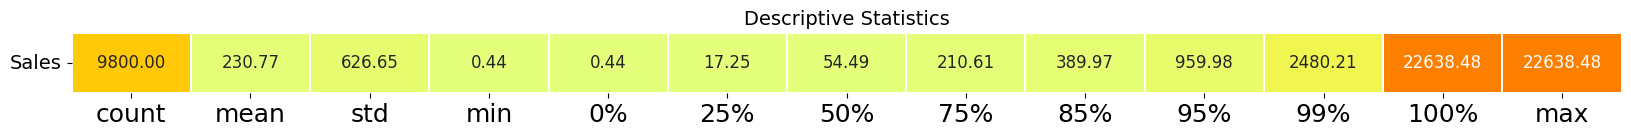

In [10]:
from matplotlib import pyplot as plt
from matplotlib import figure
def desc_stats(dataframe):
    desc = dataframe.describe(percentiles =[0, 0.25, 0.50, 0.75, 0.85, 0.95, 0.99, 1]).T
    desc_df = pd.DataFrame(index= dataframe.columns, 
                           columns= desc.columns,
                           data= desc)
    
    f,ax = plt.subplots(figsize=(20,
                                 desc_df.shape[0]*0.78))
    sns.heatmap(desc_df,
                annot=True,
                cmap = "Wistia",
                fmt= '.2f',
                ax=ax,
                linecolor='white',
                linewidths = 1.3,
                cbar = False,
                annot_kws={"size": 12})
    plt.xticks(size = 18)
    plt.yticks(size = 14,
               rotation = 0)
    plt.title("Descriptive Statistics", size = 14)
    plt.show()


desc_stats(df[[col for col in df.columns if df[col].dtype in ['int64', 'float64'] ]])

- As you can see, the maximum value of the sales variable in the data set is much larger than the quantile value of 0.99. But the situation where the values are seen low starts after 85%. When looked at, the sales variable, which was normal up to 75%, showed an increase of ~3x between 85% and 95%.

In [11]:
customer_sales = df.groupby('Customer Name').agg({'Sales':"sum"}).reset_index().sort_values(by = "Sales", ascending = False)[:10]



fig = px.bar(customer_sales, x='Customer Name', y='Sales', hover_data=['Customer Name', 'Sales'],
             labels={'Customer Name': 'Customer Name', 'Sales': 'Sales'}, 
              template='plotly_dark', color = 'Sales')


fig.update_traces(hovertemplate='Customer Name: %{x}<br>Sales: $%{y}<extra></extra>')

fig.update_layout(title='Top 10 Customer',width=1200, height=600)

fig.update_traces(text=customer_sales['Sales'], 
                  texttemplate='$%{text:.2f}', 
                  textfont=dict(color='white', size=14, family='Arial'),
                  textangle=0,textposition='outside')


fig.show()

In [12]:
segment_sales = df.groupby('Segment').agg({"Sales":"sum"}).reset_index().sort_values(by = "Sales", ascending = False)


fig = go.Figure(data=[go.Pie(labels=segment_sales['Segment'],
                             values=segment_sales['Sales'],
                            textinfo='label+percent',
                             hovertemplate='<b>%{label}</b><br>' +
                                           'Sales: %{value}<br>' +
                                           '<extra></extra>')])


fig.update_layout(title="Sales values by Costumer Segment",width=900, height=600)



fig.update_traces(textfont=dict(color='white', size=12, family='Arial'),
                  insidetextfont=dict(color='white', size=12, family='Arial'))



fig.show()

In [13]:
import plotly.express as px
import pandas as pd

state_city_sales = df.groupby(['State', 'City']).agg({'Sales': 'sum',
                                                               'Order ID': lambda orderid: orderid.nunique()}).rename(columns = {'Sales': 'Total Sales', 'Order ID': 'Order Count'}).reset_index().sort_values(by=["Total Sales", 'City'], ascending=False)[:25]

fig = px.sunburst(state_city_sales, path=['State', 'City'], values='Total Sales',
                  title='Sales by State and City', color = 'Total Sales')

fig.update_traces(hovertemplate='State: %{parent}<br>City: %{label}<br>Total: $%{value:.2f}<extra></extra>')
fig.update_layout(title='Sales by State and City', width=1200, height=600)

fig.show()

- When we group the sales values by state and cities, we see that New York City has the highest Sales Value in the chart that appears. But in ranking by State Level, we see that the state of California(CA) has more Sales Value than other states. In other words, a sequence appears as New York City > LA > San Francisco > San Diego... to be more precise.

- In addition to the sales values, I would like to examine the number of orders that came to the store for the products purchased from these cities. I want to see if the sales value and the order numbers are related to each other.

*When you want to examine in more detail on the graphic, it will be enough to click on one of the State/City levels. You can click on the chart again to exit the relevant filtering. *

In [14]:
state_city_sales.head(10)

,State,City,Total Sales,Order Count
387,New York,New York City,252463,439
62,California,Los Angeles,173420,378
582,Washington,Seattle,116106,210
89,California,San Francisco,109041,261
460,Pennsylvania,Philadelphia,108842,262
518,Texas,Houston,63956,186
199,Illinois,Chicago,47820,166
88,California,San Diego,47521,88
293,Michigan,Detroit,42447,53
152,Florida,Jacksonville,39133,38


- As can be seen from this table, NYC, with the highest sales revenue, also tops the list as the City with the most orders. A clearer depiction of the pass chart above can be seen in the two barplots below.

In [15]:
state_sales = df.groupby('State').agg({'Sales':"sum", "Order ID": lambda orderid: orderid.nunique()}).reset_index().sort_values(by = "Sales", ascending = False)[:21]



fig = px.bar(state_sales, x='State', y='Sales', hover_data=['State', 'Sales'],
             labels={'State': 'State', 'Sales': 'Sales'}, 
              template='plotly_dark', color = 'Sales')


fig.update_traces(hovertemplate='State: %{x}<br>Sales: $%{y}<extra></extra>')

fig.update_layout(title='Sales Values by State',width=1200, height=600)

fig.update_traces(text=state_sales['Sales'], 
                  texttemplate='$%{text:.2f}', 
                  textfont=dict(color='white', size=14, family='Arial'),
                  textangle=0,textposition='outside')


fig.show()

In [16]:
state_sales = df.groupby('State').agg({'Sales':"sum", "Order ID": lambda orderid: orderid.nunique()}).reset_index().sort_values(by = "Sales", ascending = False)[:21]



fig = px.bar(state_sales, x='State', y='Order ID', hover_data=['State', 'Order ID'],
             labels={'State': 'State', 'Order ID': 'Order ID'}, 
              template='plotly_dark', color = 'Sales')


fig.update_traces(hovertemplate='State: %{x}<br>Order Count: %{y}<extra></extra>')

fig.update_layout(title='Order Counts by State',width=1200, height=600)

fig.update_traces(text=state_sales['Order ID'], 
                  texttemplate='%{text:.2f}', 
                  textfont=dict(color='white', size=14, family='Arial'),
                  textangle=0,textposition='outside')


fig.show()

- In our dataset, there are 3 segments: Corporate, Home Office and Consumer. These customer segments indicate the nature of the customers who shop in the store. (Another possibility may be specifying the type of invoices the store has issued.)

- When we look at the distribution in the data set, we see that the most individual customers shop. Corporate followed by consumers with a 30.5% share.

- Well, I wonder in which categories and in which sub-categories these sales took place.

In [17]:
cate_sub_cat_sales = df.groupby(['Segment', 'Category', 'Sub-Category'])['Sales'].sum().reset_index().sort_values(by = "Sales", ascending = False)[:50]


fig = px.sunburst(cate_sub_cat_sales, path=['Segment', 'Category','Sub-Category'], values='Sales',
                  title='Sales by Category and Sub-Category', color='Sales')

fig.update_traces(hovertemplate='Segment: %{id}<br>Category: %{parent}<br>Sub-Category: %{label}<br>Sales: $%{value:.2f}<extra></extra>')
fig.update_layout(title='Sales by Category and Sub-Category',width=900, height=600)

fig.show()

- In this chart, we can see how much the segments spend in which categories and subcategories.

- In the Consumer segment, which is the segment with the highest sales, sales were realized in Tekenology, furniture and office supplies, respectively. In the technology category, we see that the highest number of phones are sold. While the chair is the most purchased in the furniture category, binders and storage products are among the most purchased products in office supplies.

- In other segments, we see that they spend the most on technology-phones, a behavior very similar to consumer customers. Unlike consumer customers, customers in the Corporate and Home Office segments spent more on Office Products than regular furniture products. This is of course not a surprise.

In [18]:

ship_mode_sales = df.groupby(['Ship Mode', 'Category', 'Sub-Category']).agg({'Sales':"sum"}).reset_index().sort_values(by = 'Sales', ascending = False)


fig = go.Figure(data=[go.Pie(labels=ship_mode_sales['Ship Mode'],
                             values=ship_mode_sales['Sales'],
                            textinfo='label+percent',
                             hovertemplate='<b>%{label}</b><br>' +
                                           'Sales: $%{value}<br>' +
                                           '<extra></extra>')])


fig.update_layout(title="Sales values by Ship Mode",width=900, height=600)



fig.update_traces(textfont=dict(color='white', size=12, family='Arial'),
                  insidetextfont=dict(color='white', size=12, family='Arial'))



fig.show()

In [19]:
import plotly.express as px
import pandas as pd

fig = px.sunburst(ship_mode_sales, path=['Ship Mode', 'Category', 'Sub-Category'], values='Sales',
                  title='Sales by Category and Sub-Category', color='Sales')

fig.update_traces(hovertemplate='Ship Mode: %{id}<br>Category: %{parent}<br>Sub-Category: %{label}<br>Sales: $%{value:.2f}<extra></extra>')
fig.update_layout(title='Sales by Category and Sub-Category',width=900, height=600)

fig.show()

- When we examine the purchased products according to the type of shipment, the result we see is that the shipment was made in the standard class category at most. The highest technology expenditures were realized in shipments made in First Class and Same Day class.

## Exploratory Data Analysis - Time Series Analysis :

In [20]:
df.head()

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Month-Year
0,CA-2017-152156,2017-08-11,2017-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,262,Aug-2017
1,CA-2017-152156,2017-08-11,2017-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",732,Aug-2017
2,CA-2017-138688,2017-12-06,2017-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,15,Dec-2017
3,US-2016-108966,2016-11-10,2016-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,958,Nov-2016
4,US-2016-108966,2016-11-10,2016-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22,Nov-2016


In [21]:
df['WeekDay'] = df['Order Date'].dt.day_name()

In [22]:
start_date = df['Order Date'].min()
df['Week'] = ((((df['Order Date'] - start_date).dt.days)/7) +1).astype(int)

In [23]:
df_plot = df[['Order Date', 'Sales', 'Product ID']].groupby(['Order Date']).agg({'Sales': 'sum', 'Product ID': 'count'}).rename(columns = {'Sales': 'Total Sales', 'Product ID':'Item Count'}).reset_index()
fig = px.line(df_plot, x="Order Date", y="Item Count", title='Total Sales by Date')
fig.show()

- As seen in the figure, there is no clear pattern in the sales according to the number of products, however, upon careful examination, we can see that there is a seasonality.

In [24]:
fig = px.line(df_plot, x="Order Date", y="Total Sales", title='Total Sales by Date')
fig.show()

- When we draw a line plot according to the Total Sales Value, there is no clear seasonality pattern. When examined carefully, this seasonality can be seen as in the number of products. At the same time, a trend for the data is not seen in the daily period. Later, we will find the stationarity and seasonality of the data with tests.

- What I want to see now is whether there is a difference between the sales realized on the days of the week or not.

- That is, I want to see the days of the week by grouping them in order to see if the product sales peak on certain days of the week.

In [25]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

df_plot_dayofweek = df[['WeekDay', 'Sales', 'Product ID']].groupby(['WeekDay']).agg({'Sales': 'sum', 'Product ID': 'count'}).rename(columns = {'Sales': 'Total Sales', 'Product ID':'Item Count'}).reset_index()

df_plot_dayofweek = df_plot_dayofweek.set_index('WeekDay').loc[day_order].reset_index()

fig_dayofweek = px.bar(df_plot_dayofweek, x = 'WeekDay', y = 'Item Count',hover_data=['WeekDay', 'Item Count'], 
                       labels={'WeekDay': 'WeekDay', 'Item Count': 'Item Count'}, 
                        template='plotly_dark', color = 'Item Count')
    
fig_dayofweek.update_traces(hovertemplate='WeekDay: %{x}<br>Item Count: %{y}<extra></extra>')

fig_dayofweek.update_layout(title='Total Sales by Day Of Week',width=1200, height=600)

fig_dayofweek.update_traces(text=df_plot_dayofweek['Item Count'], 
                  texttemplate='%{text:.2f}', 
                  textfont=dict(color='white', size=14, family='Arial'),
                  textangle=0,textposition='outside')
fig_dayofweek.show()

- As can be clearly seen in the chart, sales (Items Counts) peak on some Tuesdays and decrease until Thursday. On the weekends, they continue to rise again.

In [26]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

df_plot_dayofweek = df[['WeekDay', 'Sales', 'Product ID']].groupby(['WeekDay']).agg({'Sales': 'sum', 'Product ID': 'count'}).rename(columns = {'Sales': 'Total Sales', 'Product ID':'Item Count'}).reset_index()

df_plot_dayofweek = df_plot_dayofweek.set_index('WeekDay').loc[day_order].reset_index()

fig_dayofweek = px.bar(df_plot_dayofweek, x = 'WeekDay', y = 'Total Sales',hover_data=['WeekDay', 'Total Sales'], 
                       labels={'WeekDay': 'WeekDay', 'Total Sales': 'Total Sales'}, 
                        template='plotly_dark', color = 'Total Sales')
    
fig_dayofweek.update_traces(hovertemplate='WeekDay: %{x}<br>Total Sales: %{y}<extra></extra>')

fig_dayofweek.update_layout(title='Total Sales by Day Of Week',width=1200, height=600)

fig_dayofweek.update_traces(text=df_plot_dayofweek['Total Sales'], 
                  texttemplate='%{text:.2f}', 
                  textfont=dict(color='white', size=14, family='Arial'),
                  textangle=0,textposition='outside')
fig_dayofweek.show()

- When we look at the sales values and the number of products sold by day separately, the highest product sales are on Tuesday and continue as Tuesday - Saturday - Monday. But according to the days, the revenues from the product sales continue as Saturday, Tuesday, Monday, Wednesday. Sunday, which is in the top rank in product sales, is in the lower rank in the revenues obtained.


- So as a comment we can make, items with more value in value were ordered on Saturday. Since Tuesday is at the top of both charts, the products sold can be considered both as a large number and as valuable products. For Wednesday, as in Saturday, few but more valuable products were ordered.

In [27]:
SINGLE_YEAR = 2017

df_sales_single_year = df[df['Order Date'].dt.year == SINGLE_YEAR]
df_plot_single_year = df_sales_single_year[['Order Date','Sales','Product ID']].groupby(['Order Date']).agg({'Sales': 'sum', 'Product ID':'count'}).rename(columns = {'Sales':'Total Sales', 'Product ID': 'Item Count'}).reset_index() 
fig = px.bar(df_plot_single_year, x='Order Date', y='Item Count',facet_col_spacing=0, title=f'Total Sales by Day {SINGLE_YEAR}')
fig.update_layout(bargap=0.0,bargroupgap=0.0, height = 600, width = 1200)
fig.show()

- Unique Item ID's

In [28]:
df['Product ID'].unique()

array(['FUR-BO-10001798', 'FUR-CH-10000454', 'OFF-LA-10000240', ...,
       'TEC-MA-10003589', 'OFF-AP-10003099', 'TEC-PH-10002645'],
      dtype=object)

In [29]:
df_pop_items = df[['Product Name', 'Sales', 'Product ID']].groupby(['Product Name']).agg({'Sales' : 'sum','Product ID' : 'count'}).rename(columns = {'Product ID' : 'Item Count', 'Sales' : 'Total Sales'}).reset_index().sort_values(by  = 'Item Count', ascending = False)
df_pop_items[:10]

,Product Name,Total Sales,Item Count
1492,Staple envelope,1676,47
1498,Staples,755,46
537,Easy-staple paper,2414,44
259,Avery Non-Stick Binders,217,20
1495,Staple remover,263,18
1499,Staples in misc. colors,460,18
941,KI Adjustable-Height Table,4467,17
1510,Storex Dura Pro Binders,279,17
1496,Staple-based wall hangings,422,16
992,Logitech 910-002974 M325 Wireless Mouse for We...,1410,15


-  In the above list, we see the products with the highest sales in terms of income (Total Sales) and the number of purchases (Item Count) provided to the store. The highest sales amount is seen as 'Staple Envelope' according to the number of units.

I would like to rank the same list according to the income they provide.

In [30]:
df_pop_items2 = df[['Product Name', 'Sales', 'Product ID']].groupby(['Product Name']).agg({'Sales' : 'sum','Product ID' : 'count'}).rename(columns = {'Product ID' : 'Item Count', 'Sales' : 'Total Sales'}).reset_index().sort_values(by  = 'Total Sales', ascending = False)
df_pop_items2[:10]

,Product Name,Total Sales,Item Count
404,Canon imageCLASS 2200 Advanced Copier,61600,5
649,Fellowes PB500 Electric Punch Plastic Comb Bin...,27453,10
444,Cisco TelePresence System EX90 Videoconferenci...,22638,1
785,HON 5400 Series Task Chairs for Big and Tall,21871,8
685,GBC DocuBind TL300 Electric Binding System,19823,11
687,GBC Ibimaster 500 Manual ProClick Binding System,19024,9
804,Hewlett Packard LaserJet 3310 Copier,18840,8
786,HP Designjet T520 Inkjet Large Format Printer ...,18375,3
682,GBC DocuBind P400 Electric Binding System,17965,6
812,High Speed Automatic Electric Letter Opener,17030,3


- When we sort the list in this way, we see more of the effect on the sales value of some products. For example, the price paid for the product named 'Cisco TelePresence System EX90 Videoconferenci...' is $22638, even if one purchase is made. It's a pretty expensive item.

In [31]:
df_plot = df_sales_single_year[['Order Date','Product Name', 'Sales','Product ID']].groupby(['Order Date','Product Name']).agg({'Sales':'sum', 'Product ID':'count'}).rename(columns = {'Sales': 'Total Sales', 'Product ID': 'Item Count'}).reset_index()
fig = px.bar(df_plot, x='Order Date', y='Total Sales',color="Product Name", title=f'Item Sales by Date - {SINGLE_YEAR}')
fig.update_layout(bargap=0.0,bargroupgap=0.0, height = 600, width = 1200)
fig.show()

In [32]:
df_plot_weekly = df_sales_single_year[['Week','Product Name','Product ID','Sales']].groupby(['Week','Product Name']).agg({'Sales':'sum', 'Product ID': 'count'}).rename(columns = {'Sales': 'Total Sales', 'Product ID' : 'Item Count'}).reset_index()
fig = px.bar(df_plot_weekly, x='Week', y='Total Sales',color="Product Name", title=f'Total Sales by Week - {SINGLE_YEAR}')
fig.update_layout(bargap=0.0,bargroupgap=0.0, height = 600 , width = 1200)
fig.show()

In [33]:
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

df_plot_daily = df[['WeekDay','Product Name','Sales']].groupby(['WeekDay','Product Name']).agg({'Sales':'sum'}).rename(columns = {'Sales':'Total Sales'}).reset_index()
df_plot_daily = df_plot_daily.set_index('WeekDay').loc[day_order].reset_index()
fig = px.bar(df_plot_daily, x='WeekDay', y='Total Sales',color="Product Name", title=f'Total Sales by Day of Week - {SINGLE_YEAR}')
fig.update_layout(bargap=0.0,bargroupgap=0.0, height = 600 , width = 900)
fig.show()

- When I look at it, when I want to display the sales by grouping them according to the products, a clear pattern is not seen. That's why I want to group according to Sub-Category variable, not by products.

In [34]:
df_pop_cats = df[['Sub-Category', 'Sales', 'Product ID']].groupby(['Sub-Category']).agg({'Sales' : 'sum','Product ID' : 'count'}).rename(columns = {'Product ID' : 'Item Count', 'Sales' : 'Total Sales'}).reset_index().sort_values(by  = 'Total Sales', ascending = False)
df_pop_cats[:10]

,Sub-Category,Total Sales,Item Count
13,Phones,327782,876
5,Chairs,322823,607
14,Storage,219343,832
16,Tables,202811,314
3,Binders,200029,1492
11,Machines,189239,115
0,Accessories,164187,756
6,Copiers,146248,66
4,Bookcases,113813,226
1,Appliances,104618,459


In [35]:
df_plot_sc = df_sales_single_year[['Order Date','Sub-Category', 'Sales','Product ID']].groupby(['Order Date','Sub-Category']).agg({'Sales':'sum', 'Product ID':'count'}).rename(columns = {'Sales': 'Total Sales', 'Product ID': 'Item Count'}).reset_index()
fig = px.bar(df_plot_sc, x='Order Date', y='Total Sales',color="Sub-Category", title=f'Item Sales by Date - {SINGLE_YEAR}')
fig.update_layout(bargap=0.0,bargroupgap=0.0, height = 600, width = 900)
fig.show()

In [36]:
df_plot_sc_weekly = df_sales_single_year[['Week','Sub-Category','Product ID','Sales']].groupby(['Week','Sub-Category']).agg({'Sales':'sum', 'Product ID': 'count'}).rename(columns = {'Sales': 'Total Sales', 'Product ID' : 'Item Count'}).reset_index()
fig = px.bar(df_plot_sc_weekly, x='Week', y='Total Sales',color="Sub-Category", title=f'Total Sales by Week - {SINGLE_YEAR}')
fig.update_layout(bargap=0.0,bargroupgap=0.0, height = 600 , width = 900)
fig.show()

In [37]:
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

df_plot_sc_daily = df[['WeekDay','Sub-Category','Sales']].groupby(['WeekDay','Sub-Category']).agg({'Sales':'sum'}).rename(columns = {'Sales':'Total Sales'}).reset_index()
df_plot_sc_daily = df_plot_sc_daily.set_index('WeekDay').loc[day_order].reset_index()
fig = px.bar(df_plot_sc_daily, x='WeekDay', y='Total Sales',color="Sub-Category", title=f'Total Sales by Day of Week - {SINGLE_YEAR}')
fig.update_layout(bargap=0.0,bargroupgap=0.0, height = 600 , width = 900)
fig.show()

- When we examine the sales change in the Phones category, which is the sub-category with the highest sales value, we see that the highest phone sales were realized on Monday and the Tuesday following Monday. Thursday was the day when the phone sales values watched the least due to the general decline in store sales. But on Thursday, although all sales are low, the largest share of daily sales belongs to the phone subcategory.

- Another pattern we can see in the chart is the sales in the Machines subcategory. Machines sales seem to have reached the highest sales figures on Wednesday and Sunday.

- Chairs sub-category in furniture is on a regular sales chart. When attention is paid, it can be seen that Tuesday and Saturday are the days when the most chairs are sold.

- Now, before moving on to the modeling, preprocessing part, I want to examine the stationarity and seasonality of the series in order to complete the time series analysis. I want to see if there is a seasonality or stationarity in our series.

In [38]:
df['Month-Year'] = df['Order Date'].dt.strftime('%b-%Y')

monthly_sales = df.groupby('Month-Year').agg({'Sales': 'sum'}).reset_index()
monthly_sales['Order'] = pd.to_datetime(monthly_sales['Month-Year'], format='%b-%Y')
monthly_sales = monthly_sales.sort_values('Order')


fig = px.line(monthly_sales, x='Month-Year', y='Sales', title='Monthly Sales',
              labels={'Month-Year': 'Month-Year', 'Sales': 'Sales'})

fig.update_traces(hovertemplate='Date: %{x}<br>Sales: $%{y:,.2f}<extra></extra>')


fig.update_xaxes(tickangle=90, tickmode='array', tickvals=monthly_sales['Month-Year'],
                 ticktext=monthly_sales['Month-Year'])


fig.update_layout(width=900, height=600)


fig.show()

- At first glance, we can clearly see that there is a trend in the time series. When we want to group and see the sales according to Month-Year, we can clearly see that the sales increase depending on time.

- The other cases I will test will be seasonality, circularity and stagnation tests. In the overview, we see that there is a seasonality of the series. The series has reached peak points at certain intervals . Circularity is actually a concept similar to seasonality. Although it does not have much qualifications in forecasting processes, I think it is useful to know. It is the event of a series repeating a certain pattern at certain intervals. As an example, we expect ice cream sales to increase in the summer months, so in a scenario we modeled ice cream sales, we will be able to see that it always follows the same pattern in the summer months.

In [39]:
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d/%m/%Y')
df_sorted = df.sort_values(by= ['Order Date'],  ascending=True)

df_sorted = df_sorted.set_index("Order Date")


df_time = pd.DataFrame(df_sorted['Sales'])

df_time =  pd.DataFrame(df_time['Sales'].resample('D').mean())
df_time = df_time.interpolate(method='linear')

In [40]:
def is_stationary(y):

    # "HO: Non-stationary"
    # "H1: Stationary"

    p_value = sm.tsa.stattools.adfuller(y)[1]
    if p_value < 0.05:
        print(F"Result: Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")
    else:
        print(F"Result: Non-Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")

In [41]:
is_stationary(df_time)

Result: Stationary (H0: non-stationary, p-value: 0.0)


- To test whether the series is stationary, we use the adfuller test in the statsmodels library. According to this test, we got the result that our data set is stationary. This is interesting because when we drew the line graph, we saw that the dataset was in an upward trend. Let's do our other tests...

In [42]:
import matplotlib.pyplot as plt
def ts_decompose(y, model="additive", stationary=False):
    result = sm.tsa.seasonal_decompose(y, model=model)
    fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
    fig.set_figheight(8)
    fig.set_figwidth(10)

    axes[0].set_title("Decomposition for " + model + " model")
    axes[0].plot(y, 'k', label='Original ' + model)
    axes[0].legend(loc='upper left')

    axes[1].plot(result.trend, label='Trend')
    axes[1].legend(loc='upper left')

    axes[2].plot(result.seasonal, 'g', label='Seasonality & Mean: ' + str(round(result.seasonal.mean(), 4)))
    axes[2].legend(loc='upper left')

    axes[3].plot(result.resid, 'r', label='Residuals & Mean: ' + str(round(result.resid.mean(), 4)))
    axes[3].legend(loc='upper left')
    plt.show(block=True)

    if stationary:
        is_stationary(y)

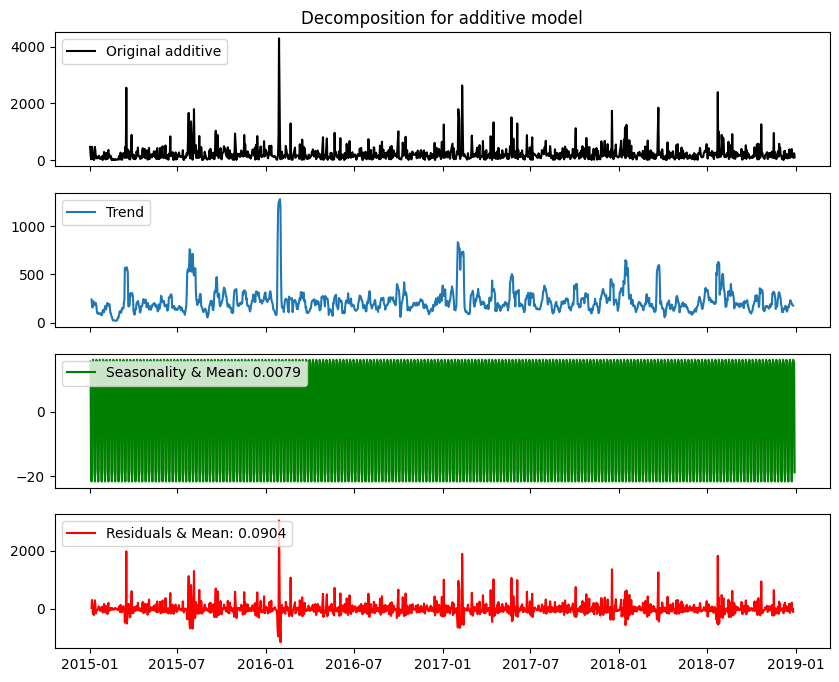

Result: Stationary (H0: non-stationary, p-value: 0.0)


In [43]:
ts_decompose(df_time, stationary=True)

- We now agree that the Dataset is stationary. With the tests we have done, we have seen that our interpretation of 'The data set is in an upward trend' is not true.

- I would like to explain the above chart simply. In this image, the top chart provides us with the level information of the data set and allows us to make up our minds about whether the series is stationary or not. The second chart provides trend information, the third chart seasonality information. Finally, the Residuals graph shows the residuals. The residuals show the deviation levels around the data. In the expected case, the mean of the residues around zero is 0.

- I finished to EDA & Time Series Analysis, I will build some ML or DL model. See u soon :)